# Level 1: Local Frog Discovery Tool benchmark notebook

## Challenge Level 1 Overview


Welcome to the 2022 EY Data Science Challenge! This is the first challenge aimed at beginner/intermediate participants that have little to no experience in data science and programming. For more experienced participants, we recommend undertaking challenge level 2 outlined [here](Model_Level_2.ipynb). If you choose to undertake the first level of the challenge, you will be developing a species distribution model (SDM) for one Australian frog species using only variables from the TerraClimate dataset. A species distribution model is a specific type of machine learning model that aims to predict the distribution of a biological species across geographic space and time. Such models have become increasingly important in conservation efforts globally to better understand and map the habitats of species of interest, particularly threatened or endangered species. 

The frog species identified for this challenge is Litoria fallax, the eastern dwarf tree frog pictured below. In addition to assisting our understanding of this specific frog species, a successful frog SDM will have broader implications in quantifying biodiversity. This is because frogs are incredibly sensitive to environmental changes, so any changes in their species distribution may indicate an underlying change to biodiversity in the area. 

<center>
<img src="../Assesment/pictures/Litoria_fallax.jpg" width="200" height="200">
</center>

<br>

**Challenge aim:** to develop a species distribution model for litoria fallax across Australia using weather data from the TerraClimate dataset.

| Challenge | Locations                     | Spatial Res        | Species          | Satellite Data                                                |
|-----------|-------------------------------|--------------------|------------------|---------------------------------------------------------------|
|***1***    | Australia                     | Coarse (4km)  | 1 species  | TerraClimate                                                  |
|2     | Australia, Costa Rica,<br>South Africa | Fine (10m)   | 15 species     | TerraClimate, Sentinel-2,<br>Land cover, water extent, elevation |

## Load in dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take a while. 

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pickle

# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Data science
import pandas as pd
import numpy as np
import scipy
from numpy import arange
from numpy import argmax

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix
from xgboost.sklearn import XGBClassifier

# Geospatial
import contextily as cx
import xarray as xr
import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac

# Other
import os
import zipfile
from itertools import cycle
import math

# Notebook
from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.initializers import Constant

import seaborn as sns
from scipy import stats

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (12, 10)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import tempfile


## Notebook configurations

Since this notebooks is used to build multiple models and data processing configurations, we will define the settings for this run.

In [3]:
SHOW_PLOTS = True

data_attempt_name = "5"
code_attempt_name = "1"

# Define sampling region
region_name = 'Sumbission Area'

# Year range
year_range = (2009, 2019)

# Terraclimate: Number of climate years before each record
years_shift_build_dataset = 3
years_shift_predict = 4

# dataset
output_model_data = f'preprocessed/challenge_1_model_data_{data_attempt_name}.csv'

# Partial frog data
bbox_try_select = "TimesSubmission"
bbox_try = "TimesSubmission_2x"
bbox_N_sizes = 2

# dist_calc = "calc_exp_closest"
dist_calc = "calc_closest"

# Balance data
N_largest_rate = 0.5
config_weights = None

# Terraclimate data
threshold_by_bbox = True

# Submission output file
output_submission = f'challenge_1_submission_benchmark_keras_D{data_attempt_name}_A{code_attempt_name}_bboxthr.csv'

## Challange resources

Before starting the data processing and building the model, we load all the resources provided for this challange.

In [4]:
# Import submission dataset
submission_df = pd.read_csv('challange/Level_1_challenge_1_submission_template.csv')
submission_df.describe().loc[['min','max','mean','std']]

# Describe submission dataset
subm_desc = submission_df.describe()

lat_min = subm_desc.loc[['min']]['decimalLatitude'].iloc[0].round(2)
lat_max = subm_desc.loc[['max']]['decimalLatitude'].iloc[0].round(2)

lon_min = subm_desc.loc[['min']]['decimalLongitude'].iloc[0].round(2)
lon_max = subm_desc.loc[['max']]['decimalLongitude'].iloc[0].round(2)

print((lon_min, lat_min, lon_max, lat_max))

(115.72, -38.5, 153.6, -16.74)


In [5]:
# Read in test regions
test_1_regions = []
with open('challange/challenge_1_test_regions.txt', 'r') as file: 
    for i, line in enumerate(file):
        if i > 0:
            test_1_regions.append(eval("("+line+")"))

# Load in regions and save as list of dictionaries.
test_regions = [{'title':i, 'bbox':bbox} for i, bbox in enumerate(test_1_regions)].copy()

test_regions

[{'title': 0, 'bbox': (144.8, -38.5, 145.8, -37.5)},
 {'title': 1, 'bbox': (150.7, -33.5, 151.7, -32.5)},
 {'title': 2, 'bbox': (152.6, -29.0, 153.6, -28.0)},
 {'title': 3, 'bbox': (145.0, -17.7, 146.0, -16.7)},
 {'title': 4, 'bbox': (115.7, -32.5, 116.7, -31.5)}]

In [6]:
# Load in test coordinates
test_file = pd.read_csv('challange/challenge_1_submission_template.csv')

In [7]:
# Path to data folder with provided material
dataset_path = 'challange/occurrence.txt'

# Target Species
target_species = 'Litoria Fallax'

## Helper functions

All the function that will be used on this notebook

In [8]:
# General functions

def filter_bbox(frogs, bbox):
    frogs = frogs[lambda x: 
        (x.decimalLongitude >= bbox[0]) &
        (x.decimalLatitude >= bbox[1]) &
        (x.decimalLongitude <= bbox[2]) &
        (x.decimalLatitude <= bbox[3])
    ]
    return frogs

def get_frogs(file, year_range=None, bbox=None):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""
    columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]
    country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
    continent_names = {
        'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
        'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
        'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
        'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
    }
    frogs = (
        pd.read_csv(file, sep='\t', parse_dates=['eventDate'])
        .assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )
        [columns]
    )
    if year_range is not None:
        frogs = frogs[lambda x: 
            (x.eventDate.dt.year >= year_range[0]) & 
            (x.eventDate.dt.year <= year_range[1])
        ]
    if bbox is not None:
        frogs = filter_bbox(frogs, bbox)
    return frogs

def get_terraclimate(bbox, metrics, time_slice=None, assets=None, features=None, interp_dims=None, verbose=True):
    """Returns terraclimate metrics for a given area, allowing results to be interpolated onto a larger image.
    
    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    metrics -- Nested dictionary in the form {<metric_name>:{'fn':<metric_function>,'params':<metric_kwargs_dict>}, ... }
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    features -- list of asset metrics to take, specified by strings in the form '<asset_name>_<metric_name>'
    interp_dims -- Tuple of dimensions (n, m) to interpolate results to
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    
    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.extra_fields["assets"]["zarr-https"]
    store = fsspec.get_mapper(asset["href"])
    data = xr.open_zarr(store, **asset["xarray:open_kwargs"])
    
    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').to_array().compute()
        
    # Calculate metrics
    combined_values = []
    combined_bands = []
    for name, metric in metrics.items():
        sum_data = xr.apply_ufunc(
            metric['fn'], data, input_core_dims=[["time"]], kwargs=metric['params'], dask = 'allowed', vectorize = True
        ).rename(variable='band')
        xcoords = sum_data.x
        ycoords = sum_data.y
        dims = sum_data.dims
        combined_values.append(sum_data.values)
        for band in sum_data.band.values:
            combined_bands.append(band+'_'+name)
        
    # Combine metrics
    combined_values = np.concatenate(
        combined_values,
        axis=0
    )
    combined_data = xr.DataArray(
        data=combined_values,
        dims=dims,
        coords=dict(
            band=combined_bands,
            y=ycoords,
            x=xcoords
        )
    )    

    # Take relevant bands:
    combined_data = combined_data.sel(band=features)
    
    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        combined_data = combined_data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})
    
    return combined_data

def join_frogs(frogs, data_arr):
    """Collects the data for each frog location and joins it onto the frog data 

    Arguments:
    frogs -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """
    joined_df = pd.DataFrame ()
    for year_data in data_arr:
        year = str(year_data["time_slice"][1])[:4]
        frogs_year = frogs[frogs['eventDate'].astype(str).str.contains(year)].copy()
        filtered_years = list(set(str(date)[:4] for date in frogs_year['eventDate'].unique()))
        print(f"Timeslice: {year_data['time_slice']}. Filtered years: {filtered_years}")
        merged_year = frogs_year.merge(
                (
                    year_data["weather_data"]
                    .rename('data')
                    .sel(
                        x=xr.DataArray(frogs_year.decimalLongitude, dims="key", coords={"key": frogs_year.key}), 
                        y=xr.DataArray(frogs_year.decimalLatitude, dims="key", coords={"key": frogs_year.key}),
                        method="nearest"
                    )
                    .to_dataframe()
                    .assign(val = lambda x: x.iloc[:, -1])
                    [['val']]
                    .reset_index()
                    .drop_duplicates()
                    .pivot(index="key", columns="band", values="val")
                    .reset_index()
                ),
                on = ['key'],
                how = 'inner'
            )
        joined_df= pd.concat([joined_df, merged_year], ignore_index=True)
    return joined_df

def predict_frogs(predictor_image, model):
    """Returns a (1, n, m) xarray where each pixel value corresponds to the probability of a frog occurrence.
    
    Takes in the multi-band image outputted by the `create_predictor_image` function as well as the
    trained model and returns the predictions for each pixel value. Firstly, the $x$ and $y$ indexes
    in the predictor image are stacked into one multi-index $z=(x, y)$ to produce an $k\times n$
    array, which is the format required to feed into our logistic regression model. Then, the array
    is fed into the model, returning the model's predictions for the frog likelihood at each pixel. 
    The predicted probabilities are then indexed by the same multi-index $z$ as before, which allows 
    the array to be unstacked and returned as a one-band image, ready for plotting.

    Arguments:
    predictor_image -- (K, n, m) xarray, where K is the number of predictor variables.
    model -- sklearn model with K predictor variables.
    """
    # Stack up pixels so they are in the appropriate format for the model
    predictor_image = predictor_image.stack(z=("y", "x")).transpose()
    # Reorder variables to be in same order as model
    predictor_image = predictor_image.sel(band=model.feature_names_in_)
    # Location of null values so that we can skip them (prediction model will break if nulls are present)
    null_pixels = (np.sum(predictor_image.isnull(), axis=-1) > 0)
    # Empty probabilities array
    probabilities = np.zeros((len(null_pixels), 2))
    # Calculate probability for each non-null pixel point
    probabilities[~null_pixels] = model.predict_proba(
        predictor_image[~null_pixels]
    )
    # Set null pixels to a probability of null
    probabilities[null_pixels] = np.array([np.nan, np.nan])
    # Just take probability of frog (class=1)
    probabilities = probabilities[:,1]
    # Add the coordinates to the probabilities, saving them in an xarray
    resultant_image = xr.DataArray(
        data=probabilities,
        dims=['z'],
        coords=dict(
            z=predictor_image.z
        )
    )
    # Unstack the image
    resultant_image = resultant_image.unstack()
    return resultant_image

def predict_frogs_sequential(predictor_image, model, scaler, cols):
    """Returns a (1, n, m) xarray where each pixel value corresponds to the probability of a frog occurrence.
    
    Takes in the multi-band image outputted by the `create_predictor_image` function as well as the
    trained model and returns the predictions for each pixel value. Firstly, the $x$ and $y$ indexes
    in the predictor image are stacked into one multi-index $z=(x, y)$ to produce an $k\times n$
    array, which is the format required to feed into our logistic regression model. Then, the array
    is fed into the model, returning the model's predictions for the frog likelihood at each pixel. 
    The predicted probabilities are then indexed by the same multi-index $z$ as before, which allows 
    the array to be unstacked and returned as a one-band image, ready for plotting.

    Arguments:
    predictor_image -- (K, n, m) xarray, where K is the number of predictor variables.
    model -- sklearn model with K predictor variables.
    """
    # Stack up pixels so they are in the appropriate format for the model
    predictor_image = predictor_image.stack(z=("y", "x")).transpose()
    # Reorder variables to be in same order as model
    predictor_image = predictor_image.sel(band=cols)
    # Location of null values so that we can skip them (prediction model will break if nulls are present)
    null_pixels = (np.sum(predictor_image.isnull(), axis=-1) > 0)
    # Empty probabilities array
    probabilities = np.zeros((len(null_pixels), 2))
    # Calculate probability for each non-null pixel point

    model.predict(scaler.transform(X))
    probabilities[~null_pixels] = model.predict(scaler.transform(
        predictor_image[~null_pixels].values
    ))
    # Set null pixels to a probability of null
    probabilities[null_pixels] = np.array([np.nan, np.nan])
    # Just take probability of frog (class=1)
    probabilities = probabilities[:,1]
    # Add the coordinates to the probabilities, saving them in an xarray
    resultant_image = xr.DataArray(
        data=probabilities,
        dims=['z'],
        coords=dict(
            z=predictor_image.z
        )
    )
    # Unstack the image
    resultant_image = resultant_image.unstack()
    return resultant_image

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Plot functions

def plot_heatmap(resultant_image, frog_data, title, crs = {'init':'epsg:4326'}):
    """Plots a real map, probability heatmap, and model classification regions for the probability image from our model.

    Arguments:
    resultant_image -- (1, n, m) xarray of probabilities output from the model
    frog_data -- Dataframe of frog occurrences, indicated with a 1 in the occurrenceStatus column. 
                 Must contain ["occurrenceStatus", "decimalLongitude", "decimalLatitude"]
    title -- string that will be displayed as the figure title
    crs -- coordinate reference system for plotting the real map. Defaults to EPSG:4326.
    """
    fig, ax = plt.subplots(1, 3, figsize = (20, 10), sharex=True, sharey=True)
    extent = [resultant_image.x.min(),resultant_image.x.max(),resultant_image.y.min(),resultant_image.y.max()]
    cmap = 'PiYG'

    # Plot real map
    ax[0].scatter(x=[extent[0], extent[1]], y=[extent[2], extent[3]], alpha=0)
    cx.add_basemap(ax[0], crs=crs)
    ax[0].set_title('Real map')
    
    # Plot heatmap from model
    heatmap = resultant_image.plot.imshow(
        x='x', y='y', ax=ax[1], cmap=cmap, vmin=0, vmax=1, interpolation='none', add_colorbar=False
    )
    ax[1].set_aspect('equal')
    ax[1].set_title('Model Probability Heatmap')

    # Plot binary classification from model
    regions = xr.where(resultant_image.isnull(), np.nan, resultant_image>0.5).plot.imshow(
            x='x', y='y', ax=ax[2], cmap=cmap, vmin=0, vmax=1, interpolation='none', add_colorbar=False
    )
    ax[2].set_aspect('equal')
    ax[2].set_title('Model Classification Regions')

    # Plot real frogs
    for i, axis in enumerate(ax):
        filt = frog_data.occurrenceStatus == 1
        axis.scatter(
            frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude, 
            color = 'dodgerblue', marker='.', alpha=0.5, label='Target Species' if i==0 else ''
        )

    fig.colorbar(heatmap, ax=ax, location = 'bottom', aspect=40)
    fig.legend(loc = (0.9, 0.9))
    fig.suptitle(title, x=0.5, y=0.9, fontsize=20)

def plot_species(fig, ax, frog_data, region_name, cmap_params={'alpha':0.5}, scatter_params={'alpha':0.5}):
    # Bar chart
    bar_data = frog_data.species.value_counts()
    barchart = ax[1].bar(bar_data.index.str.replace(' ', '\n'), bar_data)

    # Colour cycle to ensure colors match in both plots
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        species_name = bar_data.index[i]
        if len(species_name) > 19:
            display_name = species_name.replace(' ', '\n')
        else:
            display_name = species_name
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{display_name}\nCount: {bar_data[i]}")
        filt = frog_data.species == species_name
        # Scatter plot
        ax[0].scatter(
            frog_data[filt].decimalLongitude, 
            frog_data[filt].decimalLatitude, 
            marker='.', 
            color=color['color'],
            **scatter_params
        )

    # Add other features
    ax[0].set_title(f"Frog occurrences for {region_name}")
    # ax[0].set_xticklabels([])
    # ax[0].set_yticklabels([])
    ax[1].set_title(f"Frog species distribution in {region_name}")
    cx.add_basemap(ax[0], crs={'init':'epsg:4326'}, **cmap_params) # Add basemap
    ax[1].set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax[1].legend()
    
def plot_barchart(bar_data, ax, bar_params={}, fold_text=True):
    barchart = ax.bar(bar_data.index, bar_data, **bar_params)
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        var_name = bar_data.index[i]
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{var_name}\nCount: {bar_data[i]}")
    ax.set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax.legend()

def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

def plot_cm(labels, predictions, p=0.5, texts=False):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  if texts:
    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100.5])
  plt.ylim([-0.5,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

## Frog data

### Geo-spatial sampling
At this point, different methods were tested to have a good representation of the region of interest, with a varied landscape of bushland, plains, rivers, and urban areas. In the code there are 4 different methods, of which the one that gave the best results was the one called TimesSubmission. In this method I use the test regions as a starting point to create extended regions around. In this way it is possible to have samples both from the east coast, which is representative of the habitat of litoria fallax, and from the western region of Australia where it is not found.The resulting map, together with the distribution of species obtained, is shown below.

### Year range sampling
For the year range sampling, I limited the search to frogs between 2009 and 2019, in order to have a wide time spectrum to observe possible movements of the frogs. Observing the temporal distribution of the dataset, it is observed that the year 2020 a peak of observations in the non-target species. Due to this, it was decided not to include that year and to have a more balanced sample, which continues to be representative.

<center>
<img src="../Assesment/pictures/Australia - Frogs over time.PNG" width="100" height="140">
</center>

In [9]:
# Partial frog data
partial_frog_data_pkl = f'preprocessed/partial_frog_data_pkl_{year_range[0]}_{year_range[1]}_{bbox_try}'
partial_frog_data = pd.DataFrame()

try:
    infile = open(partial_frog_data_pkl,'rb')
    partial_frog_data = pickle.load(infile)
    infile.close()
    print(f"Year range sampling: {year_range[0]} - {year_range[1]}")
    print(f"Geo-Spatial sampling:")
    for reg in test_regions:
        bbox = reg["bbox"]
        dist_lat = bbox[2]-bbox[0]
        dist_lon = bbox[3]-bbox[1]
        submission_bbox = (     bbox[0] - bbox_N_sizes * dist_lat,
                                bbox[1] - bbox_N_sizes * dist_lon,
                                bbox[2] + bbox_N_sizes * dist_lat,
                                bbox[3] + bbox_N_sizes * dist_lon)
        print(f'Box: {submission_bbox}')
    print(f'\nPreprocessed file found with year range {year_range[0]}-{year_range[1]} and box try {bbox_try}: {partial_frog_data_pkl}')

except FileNotFoundError:
    print("Build partial_frog_data_pkl")
    # Times Submission
    if bbox_try_select == "TimesSubmission":
        print("TimesSubmission")
        for reg in test_regions:
            print(f'Original Box: {reg["bbox"]}')
            bbox = reg["bbox"]
            dist_lat = bbox[2]-bbox[0]
            dist_lon = bbox[3]-bbox[1]
            submission_bbox = (     bbox[0] - bbox_N_sizes * dist_lat,
                                    bbox[1] - bbox_N_sizes * dist_lon,
                                    bbox[2] + bbox_N_sizes * dist_lat,
                                    bbox[3] + bbox_N_sizes * dist_lon)
            print(f'Submission Box: {submission_bbox}')
            partial_frog_data = pd.concat([partial_frog_data, get_frogs(dataset_path, year_range=year_range, bbox=submission_bbox)])
            # Pickle data
            outfile = open(partial_frog_data_pkl+"_bbox"+str({reg["title"]}),'wb')
            pickle.dump(partial_frog_data, outfile)
            outfile.close()
            print(f"Save File: {partial_frog_data_pkl}_bbox{str(reg['title'])}")
        partial_frog_data = partial_frog_data.drop_duplicates(keep="first")

    # Balance Boxes
    if bbox_try_select == "BalanceOutRegionBox":
        print("BalanceOutRegionBox")
        def dist_sampling(df, samples):
            df = df.reset_index(drop=True)
            # Calculate distance
            dist_df = pd.DataFrame(scipy.spatial.distance.cdist(
                        df[['decimalLatitude','decimalLongitude']], 
                        df[['decimalLatitude','decimalLongitude']],
                        metric='euclidean'), 
                    index=df['gbifID'], columns=df['gbifID'])
            # Calculate closests distances
            def calc_closest(row, dist_df):
                sorted_dists = sorted(dist_df[row['gbifID']].values)
                sorted_dists = [i for i in sorted_dists if i != 0]
                return sorted_dists[0]+sorted_dists[1]+sorted_dists[2]
            df["closest_dists"] = df.progress_apply(lambda x: calc_closest(x, dist_df), axis=1)
            df = df.sort_values(by=['closest_dists'], ascending=True)
            df = df.reset_index(drop=True)
            # Get Largest and Smallest distances
            N_largest = int(samples * N_largest_rate)
            N_smallest = samples - N_largest
            df_nsmallest =  df[df.index < len(df) - N_largest].sample(N_smallest, random_state=420).copy()
            df_nlargest = df[df.index >= len(df) - N_largest]
            df = pd.concat([df_nsmallest,df_nlargest]).drop(columns=['closest_dists']).reset_index(drop=True)
            return df

        non_target_to_add = 0
        for reg in test_regions:
            print(f'Box: {reg["title"]}')
            bbox = reg["bbox"]
            dist_lat = bbox[2]-bbox[0]
            dist_lon = bbox[3]-bbox[1]
            submission_bbox = (     bbox[0] - bbox_N_sizes * dist_lat,
                                    bbox[1] - bbox_N_sizes * dist_lon,
                                    bbox[2] + bbox_N_sizes * dist_lat,
                                    bbox[3] + bbox_N_sizes * dist_lon)
            # Check box balance
            box_frogs = get_frogs(dataset_path, year_range=year_range, bbox=submission_bbox)
            print(f"Box Frogs: {len(box_frogs)}")
            target = box_frogs[box_frogs.species == target_species]
            non_target = box_frogs[box_frogs.species != target_species]
            if len(target) == 0: # sample to balance
                sample_to_n = int(len(box_frogs)/10)
                box_frogs = dist_sampling(non_target, sample_to_n).copy()
                print(f"sample to balance: {len(target)} / {len(non_target)} | Sample to: {sample_to_n} | Box Frogs: {len(box_frogs)}")
            partial_frog_data = pd.concat([partial_frog_data, box_frogs])
        partial_frog_data = partial_frog_data.drop_duplicates(keep="first")

    # Balance Boxes
    if bbox_try_select == "BalanceBoxes":
        print("BalanceBoxes")
        def dist_sampling(df, samples):
            df = df.reset_index(drop=True)
            # Calculate distance
            dist_df = pd.DataFrame(scipy.spatial.distance.cdist(
                        df[['decimalLatitude','decimalLongitude']], 
                        df[['decimalLatitude','decimalLongitude']],
                        metric='euclidean'), 
                    index=df['gbifID'], columns=df['gbifID'])
            # Calculate closests distances
            def calc_closest(row, dist_df):
                sorted_dists = sorted(dist_df[row['gbifID']].values)
                sorted_dists = [i for i in sorted_dists if i != 0]
                return sorted_dists[0]+sorted_dists[1]+sorted_dists[2]
            df["closest_dists"] = df.progress_apply(lambda x: calc_closest(x, dist_df), axis=1)
            df = df.sort_values(by=['closest_dists'], ascending=True)
            df = df.reset_index(drop=True)
            # Get Largest and Smallest distances
            N_largest = int(samples * N_largest_rate)
            N_smallest = samples - N_largest
            df_nsmallest =  df[df.index < len(df) - N_largest].sample(N_smallest, random_state=420).copy()
            df_nlargest = df[df.index >= len(df) - N_largest]
            df = pd.concat([df_nsmallest,df_nlargest]).drop(columns=['closest_dists']).reset_index(drop=True)
            return df

        non_target_to_add = 0
        for reg in test_regions:
            print(f'Box: {reg["title"]}')
            bbox = reg["bbox"]
            dist_lat = bbox[2]-bbox[0]
            dist_lon = bbox[3]-bbox[1]
            submission_bbox = (     bbox[0] - bbox_N_sizes * dist_lat,
                                    bbox[1] - bbox_N_sizes * dist_lon,
                                    bbox[2] + bbox_N_sizes * dist_lat,
                                    bbox[3] + bbox_N_sizes * dist_lon)
            # Check box balance
            box_frogs = get_frogs(dataset_path, year_range=year_range, bbox=submission_bbox)
            print(f"Box Frogs: {len(box_frogs)}")
            target = box_frogs[box_frogs.species == target_species]
            non_target = box_frogs[box_frogs.species != target_species]
            if len(target) == 0: # sample to balance
                box_frogs = dist_sampling(non_target, non_target_to_add).copy()
                print(f"sample to balance: {len(target)} / {len(non_target)} | To Add: {non_target_to_add} | Box Frogs: {len(box_frogs)}")
            elif len(target) > len(non_target): # no sampling
                non_target_to_add += (len(target) - len(non_target))
                print(f"No sampling: {len(target)} / {len(non_target)} | To Add: {non_target_to_add} | Box Frogs: {len(box_frogs)}")
            elif len(target) < len(non_target): # balance box
                non_target = dist_sampling(non_target, len(target)).copy()
                box_frogs = pd.concat([target, non_target])
                print(f"balance box: {len(target)} / {len(non_target)} | To Add: {non_target_to_add} | Box Frogs: {len(box_frogs)}")
            partial_frog_data = pd.concat([partial_frog_data, box_frogs])
        partial_frog_data = partial_frog_data.drop_duplicates(keep="first")

    # MaxMin Submission
    elif bbox_try == "MaxminSubmission":
        print("MaxminSubmission")
        min_lon, min_lat = (lon_min, lat_min)  # Lower-left corner
        max_lon, max_lat = (lon_max, lat_max)  # Upper-right corner
        bbox = (min_lon, min_lat, max_lon, max_lat)
        partial_frog_data = get_frogs(dataset_path, year_range=year_range, bbox=bbox)

    # Pickle data
    outfile = open(partial_frog_data_pkl,'wb')
    pickle.dump(partial_frog_data, outfile)
    outfile.close()
    print(f"Save File: {partial_frog_data}")

partial_frog_data = (partial_frog_data.assign(occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0)))
partial_frog_data.head(3)



Year range sampling: 2009 - 2019
Geo-Spatial sampling:
Box: (142.8, -40.5, 147.8, -35.5)
Box: (148.7, -35.5, 153.7, -30.5)
Box: (150.6, -31.0, 155.6, -26.0)
Box: (143.0, -19.7, 148.0, -14.7)
Box: (113.7, -34.5, 118.7, -29.5)

Preprocessed file found with year range 2009-2019 and box try TimesSubmission_2x: preprocessed/partial_frog_data_pkl_2009_2019_TimesSubmission_2x


,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus
939,3108931336,2019-09-19,Australia,Australia,New South Wales,-36.036075,147.000688,Crinia Signifera,0
979,3108880628,2018-07-29,Australia,Australia,New South Wales,-36.056464,146.975542,Crinia Signifera,0
1413,3108871064,2018-07-07,Australia,Australia,New South Wales,-36.027700,146.981000,Crinia Signifera,0


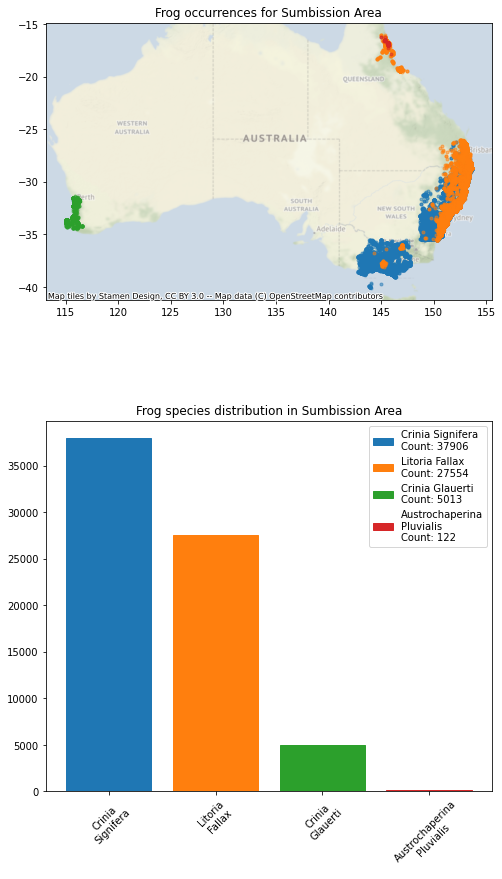

In [10]:
# Plot
if SHOW_PLOTS:
    fig, ax = plt.subplots(2, 1, figsize=(8, 15))
    plot_species(fig, ax, partial_frog_data, region_name)

## Addressing bias

### Sampling bias

As stated in the provided benchmark, frog occurrences are heavily biased around urban areas, where people are more likely to come across them. They also cluster tightly around towns, parks, bush trails etc.

After testing some methods I kept with the **pseudo-absence technique** for this species distribution modelling. This way, if a different species of frog has been sighted in a specific location, we can be more certain that the species we are trying to predict is not at that same location.

### Class Balancing

Another bias shown in the above visualisations is the class imbalance. To handle this, we will down-sample the absence points so that their numbers match that of the target species. Since random samling may cause isolated frog occurrence may be lost while clusters of occurrences are more likely to persist, I've decided to test different approches to find a smarter sampling method to improve the model. 

In order to do that, i decided to first calculate the **euclidean distance between each data point**. With this information it is possible to create representations of how isolated a point is from the others. For this, several configurations were tested, of which the most efficient was the one found in the `calc_closest` method. In this case, the **sum of the distances to the three closest points** is taken as a representation of "isolation". In this way, information on the "neighborhood" and the closest density is obtained.

In [11]:
# Calculate Distances
if (bbox_try_select != "BalanceBoxes") and not (data_attempt_name.startswith("0")):
    output_target_species_frog_data = f'preprocessed/output_target_species_frog_data_pkl_{year_range[0]}_{year_range[1]}_{bbox_try}.csv'
    output_nontarget_species_frog_data = f'preprocessed/output_nontarget_species_frog_data_pkl_{year_range[0]}_{year_range[1]}_{bbox_try}.csv'
    if dist_calc != "calc_closest":
        output_nontarget_species_frog_data = output_nontarget_species_frog_data[:-4] + "_" + dist_calc + ".csv"
    print(output_nontarget_species_frog_data)
    # Data: Frog Present 
    print('Data: Frog Present')
    try:
        target_species_frog_data = pd.read_csv(output_target_species_frog_data)
        print(f'Imported file: {output_target_species_frog_data}')
    except FileNotFoundError:
        target_species_frog_data = partial_frog_data[partial_frog_data.occurrenceStatus == 1]
        target_species_frog_data.to_csv(output_target_species_frog_data, index=None)

    # Data: Frog Absent
    print('Data: Frog Absent')
    try:
        nontarget_species_frog_data = pd.read_csv(output_nontarget_species_frog_data)
        print(f'Imported file: {output_nontarget_species_frog_data}')
    except FileNotFoundError:
        # Build Non target frog data
        nontarget_species_frog_data = partial_frog_data[lambda x: x.occurrenceStatus == 0].copy()
        print(f"Processing {len(nontarget_species_frog_data)} data points")
        # Calculate distance
        mat = scipy.spatial.distance.cdist(
                nontarget_species_frog_data[['decimalLatitude','decimalLongitude']], 
                nontarget_species_frog_data[['decimalLatitude','decimalLongitude']],
                metric='euclidean')
        # Distances df
        dist_df = pd.DataFrame(mat, index=nontarget_species_frog_data['gbifID'], columns=nontarget_species_frog_data['gbifID']) 

        if dist_calc == "calc_closest":
            # Calculate closests distances
            def calc_closest(row, dist_df):
                sorted_dists = sorted(dist_df[row['gbifID']].values)
                sorted_dists = [i for i in sorted_dists if i != 0]
                return sorted_dists[0]+sorted_dists[1]+sorted_dists[2]
            nontarget_species_frog_data["closest_dists"] = nontarget_species_frog_data.progress_apply(lambda x: calc_closest(x, dist_df), axis=1)

        elif dist_calc == "calc_exp_closest":
            # Calculate closests distances
            def calc_exp_closest(row, dist_df):
                sorted_dists = sorted(dist_df[row['gbifID']].values)
                sorted_dists = [i for i in sorted_dists if i != 0]
                return sorted_dists[0]**3 + sorted_dists[1]**2 + sorted_dists[2]
            nontarget_species_frog_data["closest_dists"] = nontarget_species_frog_data.progress_apply(lambda x: calc_exp_closest(x, dist_df), axis=1)

        nontarget_species_frog_data = nontarget_species_frog_data.sort_values(by=['closest_dists'], ascending=True)
        nontarget_species_frog_data = nontarget_species_frog_data.reset_index(drop=True)
        # Save results
        nontarget_species_frog_data.to_csv(output_nontarget_species_frog_data, index=None)
        print(f"Completed {len(nontarget_species_frog_data)} data points")

    nontarget_species_frog_data.head(3)
else:
    print("Skipping distance calculations")

nontarget_species_frog_data.sort_values("closest_dists", ascending=False).head(3)

preprocessed/output_nontarget_species_frog_data_pkl_2009_2019_TimesSubmission_2x.csv
Data: Frog Present
Imported file: preprocessed/output_target_species_frog_data_pkl_2009_2019_TimesSubmission_2x.csv
Data: Frog Absent
Imported file: preprocessed/output_nontarget_species_frog_data_pkl_2009_2019_TimesSubmission_2x.csv


,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus,closest_dists
43040,3130919169,2010-08-12 00:00:00,Australia,Australia,Victoria,-39.711670,144.995560,Crinia Signifera,0,2.848453
43039,1666910080,2015-11-18 00:00:00,Australia,Australia,Queensland,-17.825817,145.901550,Austrochaperina Pluvialis,0,2.263463
43038,1071899930,2009-09-07 00:00:00,Australia,Australia,New South Wales,-29.144986,150.994387,Crinia Signifera,0,1.560078


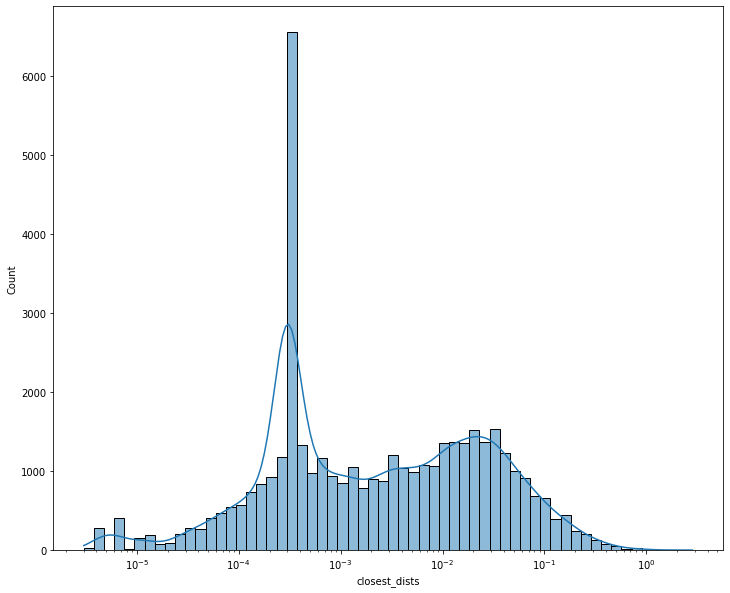

In [12]:
# Plot
if SHOW_PLOTS:
    sns.histplot(data=nontarget_species_frog_data, x="closest_dists", kde=True, log_scale=True)

Now, with the information in the `calc_dists` column, it is possible to have an idea of the "isolation" of each datapoint. Now, I am assuming that the more isolated datapoints provides more information of the location where the target species is absent, while the datapoints that are too close nay result in redundant information for the model.

With this information I decided to keep a percentage (`N_largest_rate`) of the dataspoint with largest `calc_dists` and the use random sampling for the remaining datapoints, until the number of non-target datapoints is **balanced** with the number of target datapiont. 

The usage of this method resulted in a **huge improvement** in the model accuracy since the more isolated datapoints are included in the model data, while the rest of them are sampled in a random fashion, which helps to keep the statistical representation of the original sample. This was also tested by using the `calc_dists` to weight the sampling, which resulted in reducing the accuracy while training the model.

In [13]:
if (bbox_try_select != "BalanceBoxes") and not (data_attempt_name.startswith("0")):
    print("Build balanced data")
    # Balance dataset
    N_largest = int(len(target_species_frog_data) * N_largest_rate)
    N_lowest  = len(target_species_frog_data) - N_largest

    # Data: Frog Not Present 
    total_nontarget = len(nontarget_species_frog_data)
    nontarget_species_frog_data_nsmallest =  nontarget_species_frog_data[nontarget_species_frog_data.index < total_nontarget - N_largest]
    nontarget_species_frog_data_nlargest = nontarget_species_frog_data[nontarget_species_frog_data.index >= total_nontarget - N_largest]

    # Data: Present + Absent - len(Present) -
    frog_data = (
        nontarget_species_frog_data_nsmallest.sample(N_lowest, random_state=420, weights=config_weights)
        .append(nontarget_species_frog_data_nlargest)
        .append(target_species_frog_data)
        .drop(columns=['closest_dists'])
        .reset_index(drop=True)
        .assign(key=lambda x: x.index)
    )
else:
    print("Using non balanced data")
    frog_data = (partial_frog_data.copy()
        .reset_index(drop=True)
        .assign(key=lambda x: x.index)
    )

frog_data.head(3)

Build balanced data


,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species,occurrenceStatus,key
0,1071647516,2010-05-14 00:00:00,Australia,Australia,New South Wales,-32.766629,151.869805,Crinia Signifera,0,0
1,3463668249,2019-01-01 00:00:00,Australia,Australia,New South Wales,-33.745300,151.265000,Crinia Signifera,0,1
2,3108923664,2018-10-13 00:00:00,Australia,Australia,Australian Capital Territory,-35.250844,149.148334,Crinia Signifera,0,2


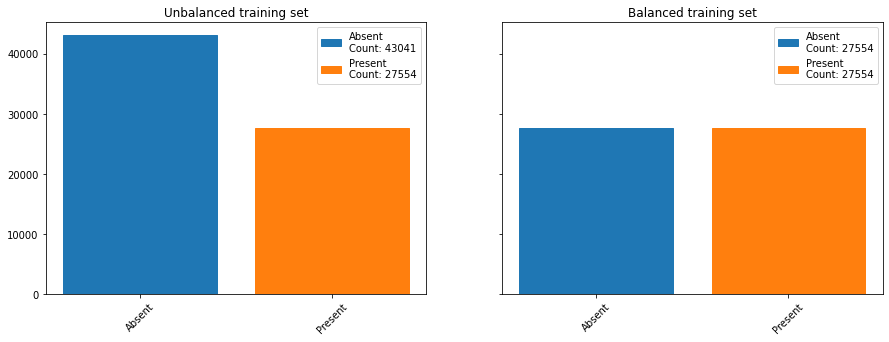

In [14]:
# Bar charts
if SHOW_PLOTS:
    fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharey=True, sharex=True)
    bar_data = partial_frog_data.occurrenceStatus.map({1:'Present', 0:'Absent'}).value_counts()
    plot_barchart(bar_data, ax[0], bar_params={})
    ax[0].set_title('Unbalanced training set')
    balanced_bar_data = frog_data.occurrenceStatus.map({1:'Present', 0:'Absent'}).value_counts()
    plot_barchart(balanced_bar_data, ax[1], bar_params={})
    ax[1].set_title('Balanced training set')

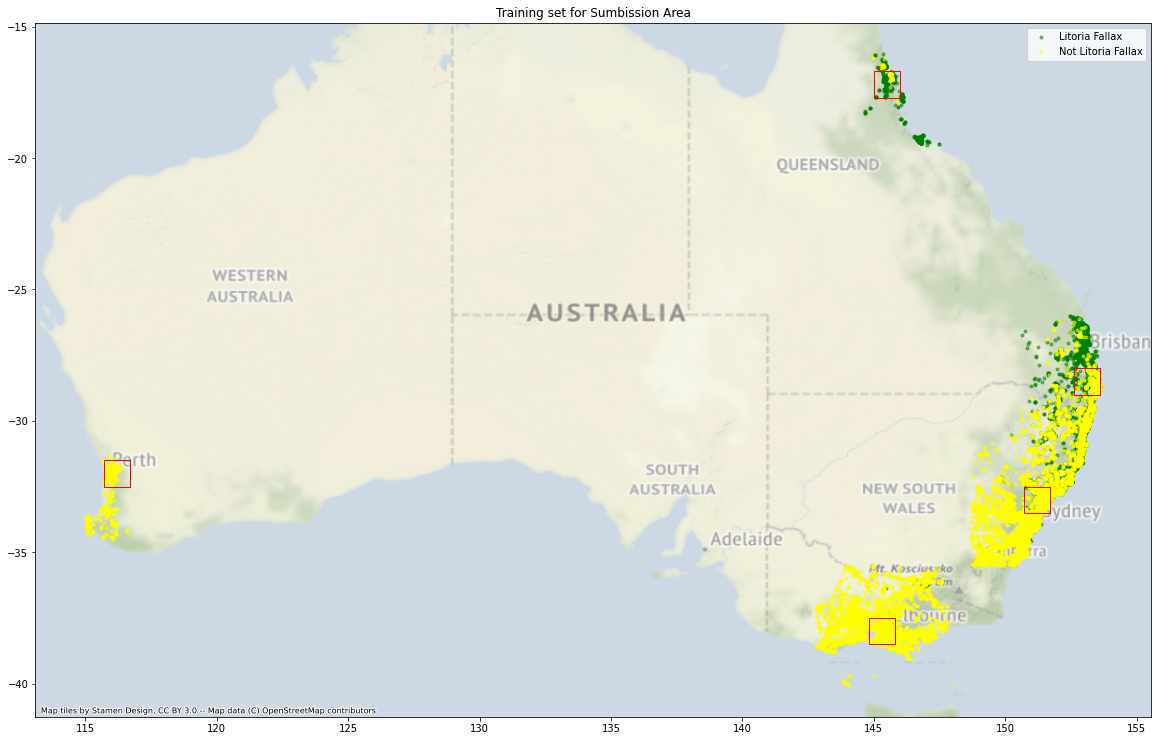

In [15]:
# Frog Map
if SHOW_PLOTS:
    fig, ax = plt.subplots(figsize = (20, 20))

    filt = frog_data.occurrenceStatus == 1
    ax.scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude,
            color = 'green', marker='.', alpha=0.5, label=target_species)
    ax.scatter(frog_data[~filt].decimalLongitude, frog_data[~filt].decimalLatitude,
            color = 'yellow', marker='.', alpha=0.5, label=f"Not {target_species}")
    ax.legend()
    cx.add_basemap(ax, crs={'init':'epsg:4326'}, alpha=0.5)
    ax.set_title(f"Training set for {region_name}")
    for reg in test_regions:
        bbox = reg["bbox"]
        rect = Rectangle((  bbox[0],bbox[1]),
                            bbox[2]-bbox[0],
                            bbox[3]-bbox[1],
                            linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)


In [16]:
try:
    del partial_frog_data
    del mat
    del target_species_frog_data
    del nontarget_species_frog_data
    del nontarget_species_frog_data_nsmallest
    del nontarget_species_frog_data_nlargest
except:
    pass

## Predictor Variables

### Temporal sampling

Highlights:

* TerraClimate predictor variables for every year in the dataset
* time_slice is 4 years
* bbox region for all Australia (within the limits of frog data)
* Adding features


For the weather to closely match the ocurrences on the dataset, i've extracted the **TerraClimate predictor variables for every year** instead of bining the data as proposed in the benchmark. This way I was able to get a more accurate climate representation of every ocurrence including only data from the same year and a **4 years span** for the calculations. So for a specific ocurrence in 2018-05-31 the terraclimate features will take in consideration only from 2015-01-01 to 2018-12-31. Using 4 years span instead of 5 was also an improvement since allowed to better identify the ocurrences with the assumption that frog occurrences within that time period are representative of the entire time period.

The extraction of such amount of data took a lot of time but resulted also in a great improvement for the model accuracy. The results of this extraction were pickled after the first run and then loaded from the stored file.

Besides the metrics already included in the benchmark, some oter were considered for the inclusion and added to the data mode such as: (`q`) Surface runoff wich is the flow of water occurring on the ground surface when excess rainwater wich could be an indicator of vegetation, (`def`) climatic water deficit, (`ws`) 10-m wind speed, etc.



In [17]:
# Terraclimate: Metrics to measure over time dimension
tc_metrics = {
    'mean':{
        'fn':np.nanmean,
        'params':{}
    },
    'std':{
        'fn':np.nanstd,
        'params':{}
    },
    'min':{
        'fn':np.nanmin,
        'params':{}
    },
    'max':{
        'fn':np.nanmax,
        'params':{}
    }
}

# Terraclimate: Measurements to take
assets=['tmax','tmin','ppt','soil','q','ws','vap','pet','aet','def']

# Terraclimate: Features to take, in form '<asset>_<metric>'
features=[  'tmax_min', 'tmax_max',
            'tmin_min', 'tmin_max',
            'ppt_mean', 'ppt_std',
            'q_mean', 'q_std', 
            'soil_min','soil_max',
            'ws_mean', 'ws_std', 
            'pet_mean','pet_std', 
            'aet_mean','aet_std', 
            'def_mean','def_std']

# Terraclimate: Interpolate values to a 512x512 image
interp_dims = (512, 512)

In [18]:
# Terraclimate bbox
min_lon, min_lat = (lon_min, lat_min)  # Lower-left corner
max_lon, max_lat = (lon_max, lat_max)  # Upper-right corner
bbox = (min_lon, min_lat, max_lon, max_lat)

In [19]:
years = sorted(list(set([int(str(date)[:4]) for date in frog_data["eventDate"].unique()])))
terraclimate_pkl = f'preprocessed/terraclimate_data_{years[0]}_{years[-1]}'

try:
    infile = open(terraclimate_pkl,'rb')
    weather_data_arr = pickle.load(infile)
    infile.close()
    print(f'Imported file: {terraclimate_pkl}')

except FileNotFoundError:
    # Date range to take
    print("Start collecting Terraclimate data for time slices:")
    time_slice_arr = []
    weather_data_arr = []
    for year in years:
        time_slice = (str(year-years_shift_build_dataset)+'-01-01',str(year)+'-12-31')
        print(time_slice)
        weather_data = get_terraclimate(bbox, tc_metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims, verbose=False)
        weather_data_arr.append({"time_slice": time_slice, "weather_data":weather_data})
    # Pickle data
    outfile = open(terraclimate_pkl,'wb')
    pickle.dump(weather_data_arr, outfile)
    outfile.close()
    print(f'Saved file: {terraclimate_pkl}')

print()
[weather_data['time_slice'] for weather_data in weather_data_arr]

Imported file: preprocessed/terraclimate_data_2009_2019



[('2006-01-01', '2009-12-31'),
 ('2007-01-01', '2010-12-31'),
 ('2008-01-01', '2011-12-31'),
 ('2009-01-01', '2012-12-31'),
 ('2010-01-01', '2013-12-31'),
 ('2011-01-01', '2014-12-31'),
 ('2012-01-01', '2015-12-31'),
 ('2013-01-01', '2016-12-31'),
 ('2014-01-01', '2017-12-31'),
 ('2015-01-01', '2018-12-31'),
 ('2016-01-01', '2019-12-31')]

### Joining Pretictors to the Response Variable

Now that I have read in our predictor variables, I join them onto the response variable of frogs. To do this, I loop through the frog occurrence data and assign each frog occurrence the closest predictor pixel value from each of the predictor variables based on the geo-coordinates for the terraclimate period associated.

In [20]:
try:
       model_data = pd.read_csv(output_model_data)
       print(f'Imported file: {output_model_data}')

except FileNotFoundError:
       # Build model data
       model_data = join_frogs(frog_data, weather_data_arr)
       all_years = list(set(str(date)[:4] for date in model_data['eventDate'].unique()))

       # Clean Model Data
       model_data = model_data.drop(['gbifID', 'eventDate', 'decimalLatitude', 'decimalLongitude', 'species',
              'country', 'continent', 'stateProvince', 'key'], 1)
       model_data = model_data.dropna(axis=0)
       model_data = model_data.reset_index().drop(["index"], axis=1)

       #Save Model data
       print(f"Save File: {output_model_data}")
       #model_data.to_csv(output_model_data, index=None)
       
       if threshold_by_bbox:
              print("Join data for partial model data regions...")
              partial_model_data_arr = []
              for reg in test_regions:
                     print(f'Box Model data: {reg["title"]}')
                     partial_frog_data = pickle.load(open(partial_frog_data_pkl+"_bbox"+str({reg["title"]}),'rb')).reset_index(drop=True).assign(key=lambda x: x.index)
                     partial_frog_data = (partial_frog_data.assign(occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0)))
                     infile.close()
                     print(f'Imported file: {partial_frog_data_pkl}')
                     partial_model_data = join_frogs(partial_frog_data, weather_data_arr)
                     # Clean Model Data
                     partial_model_data = partial_model_data.drop(['gbifID', 'eventDate', 'decimalLatitude', 'decimalLongitude', 'species',
                            'country', 'continent', 'stateProvince', 'key'], 1)
                     partial_model_data = partial_model_data.dropna(axis=0)
                     partial_model_data = partial_model_data.reset_index().drop(["index"], axis=1)
                     # Append to array
                     partial_model_data_arr.append({"bbox":reg["title"],"partial_model_data":partial_model_data})
                     # Pickle data
                     partial_model_data_arr_pkl = partial_frog_data_pkl+"_bbox_arr"
                     outfile = open(partial_model_data_arr_pkl,'wb')
                     pickle.dump(partial_model_data_arr, outfile)
                     outfile.close()
                     print(f'Saved file: {partial_model_data_arr_pkl}')

       print(f"Resulting model years: {all_years}")
       model_data.head()

model_data.sample(5)

Imported file: preprocessed/challenge_1_model_data_5.csv


,occurrenceStatus,aet_mean,aet_std,def_mean,def_std,pet_mean,pet_std,ppt_mean,ppt_std,q_mean,q_std,soil_max,soil_min,tmax_max,tmax_min,tmin_max,tmin_min,ws_mean,ws_std
17654,1,76.687500,29.446389,40.312500,41.203841,117.000000,40.156465,83.562500,61.124159,6.750000,10.753875,149.0,17.0,29.599998,17.000000,19.200005,6.099998,4.206250,0.761415
34153,1,90.750000,27.670306,26.583333,29.866253,117.250000,35.139306,106.458333,81.229346,17.375000,38.698958,174.0,25.0,29.300003,17.099998,18.700005,6.400002,4.331250,0.642312
54831,1,85.812500,37.527022,54.104167,46.947328,139.937500,27.126560,126.562500,191.793390,42.812500,133.089985,430.0,59.0,32.099998,23.400002,22.300003,13.400002,4.031250,0.938118
33394,1,81.187500,27.930461,31.895833,30.418086,113.020833,38.214575,87.708333,64.889958,9.541667,16.488580,272.0,26.0,28.800003,15.599998,19.400002,6.700005,4.091667,0.494062
5090,1,79.229167,27.771568,31.312500,39.661671,110.520833,36.237636,85.645833,56.571301,6.104167,14.065679,144.0,19.0,29.400002,16.599998,19.400002,5.599998,4.079167,0.578777


### Data correlation

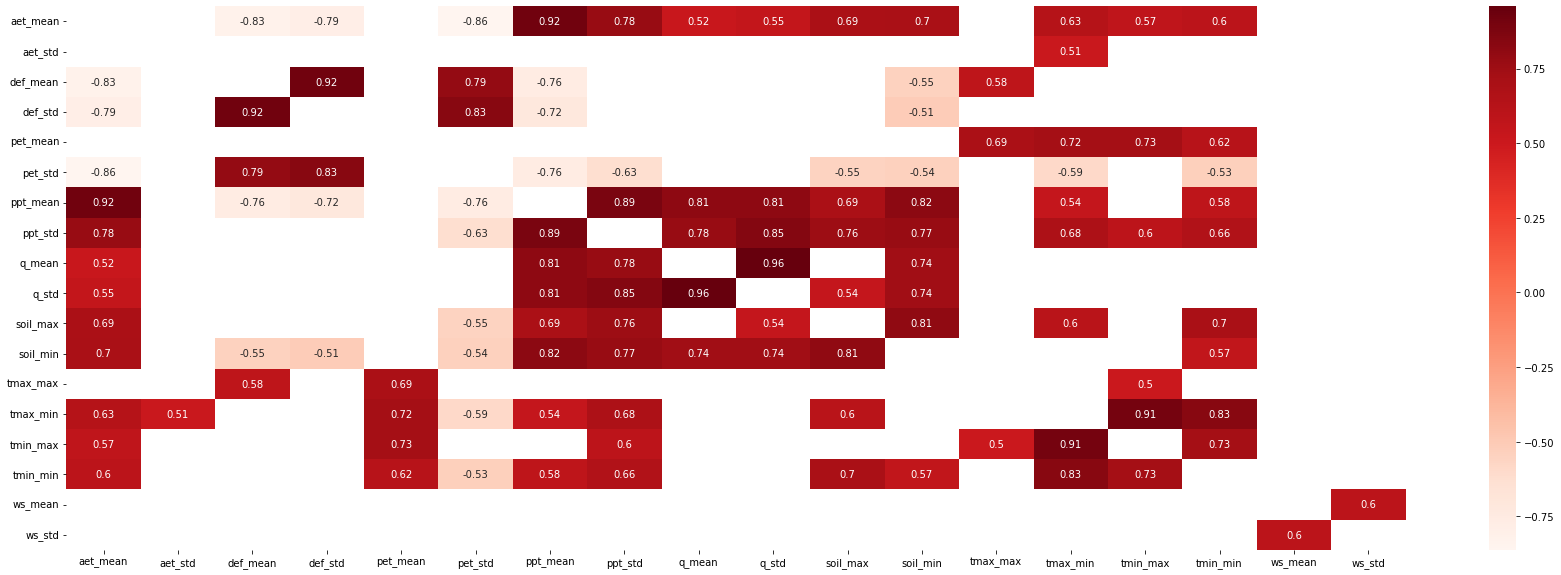

,occurrenceStatus,aet_std,def_std,pet_mean,pet_std,q_std,soil_max,soil_min,tmax_max,tmin_max,tmin_min,ws_mean,ws_std
28545,0,28.549596,34.738751,114.145833,39.828795,25.166805,131.0,11.0,30.300003,19.000000,4.300003,3.718750,0.515047
8046,1,27.771568,39.661671,110.520833,36.237636,14.065679,144.0,19.0,29.400002,19.400002,5.599998,4.079167,0.578777
15734,0,29.449396,25.798498,111.208333,34.084428,45.423810,197.0,37.0,28.700005,19.800003,6.599998,4.087500,0.670393
32432,1,26.492891,32.002543,116.583333,36.266280,41.246838,147.0,16.0,29.700005,20.000000,6.400002,4.002083,0.535214
17352,0,26.596449,50.364074,107.770833,51.931140,3.259335,95.0,7.0,31.000000,14.700005,0.700001,3.139583,0.478165


In [21]:
dfCorr = model_data.drop(columns=['occurrenceStatus']).corr()
filteredDf = dfCorr[((dfCorr >= .5) | (dfCorr <= -.5)) & (dfCorr !=1.000)]
plt.figure(figsize=(30,10))
sns.heatmap(filteredDf, annot=True, cmap="Reds")
plt.show()

# Drop highly correlated columns
drop_correlated = ['aet_mean','def_mean','q_mean','tmax_min','ppt_mean','ppt_std']
model_data = model_data.drop(columns=drop_correlated).copy()
model_data.sample(5)

### Spilt & Scale

After splitting the dataset, all the columns are scaled using the `MaxAbsScaler` wich scales each feature by its maximum absolute value. Other scaling tools were also tested such as RobustScaler, StandarScaler and even spliting the columns by skewenss and aplying different techniques. From all the techniques used the `MaxAbsScaler` was the one that resulted to be the simplest and with the better results.

In [22]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(model_data, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('occurrenceStatus'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('occurrenceStatus'))
test_labels = np.array(test_df.pop('occurrenceStatus'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)


In [23]:
scaler = MaxAbsScaler(copy=True)
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (35092,)
Validation labels shape: (8774,)
Test labels shape: (10967,)
Training features shape: (35092, 12)
Validation features shape: (8774, 12)
Test features shape: (10967, 12)


## Model Building

### Define Model

Highlights:

* Keras `Sequential` model
* 4 `Dense` layers with `Dropout` and `relu` activation function
* `Binary crossentropy` loss function and `adam` optimizer

Using the basic logistic regression model as a baseline, different algortihms were tested to imporove the performance, obtaining the best results with `XGBClassifier` and a keras Sequential model. The second one, with the layers shown below, was capable to better extract the key information from the model data provided and create a good representation of the target frog presence. 


In [46]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      f1
]

input_dim = train_features.shape[1]

def make_model(metrics=METRICS):
    def build_model():
        model = Sequential()
        model.add(Dense(500, activation='relu', input_dim=input_dim))
        model.add(Dropout(0.2))
        model.add(Dense(500, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(500, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(500, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        return model
    model = build_model()
    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=metrics)
    return model

model = make_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 500)               6500      
                                                                 
 dropout_12 (Dropout)        (None, 500)               0         
                                                                 
 dense_21 (Dense)            (None, 500)               250500    
                                                                 
 dropout_13 (Dropout)        (None, 500)               0         
                                                                 
 dense_22 (Dense)            (None, 500)               250500    
                                                                 
 dropout_14 (Dropout)        (None, 500)               0         
                                                                 
 dense_23 (Dense)            (None, 500)              

### Train Model

* Using `EarlyStopping` with validation F1 score
* Using Traingin ,

In [42]:
EPOCHS = 500
BATCH_SIZE = 500

early_stopping = EarlyStopping(
    monitor='val_f1', 
    verbose=1,
    patience=50,
    mode='max',
    restore_best_weights=True)

# Evaluate Model
model = make_model()
model_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping], 
    shuffle=True,
    validation_data=(val_features, val_labels), 
    verbose=0)


Restoring model weights from the end of the best epoch: 118.
Epoch 168: early stopping


In [27]:
# It can be used to reconstruct the model identically.
model = keras.models.load_model("model_keras.h5", custom_objects={'f1':f1})

## Model Evaluation

Now that I have trained the model, all that is left is to evaluate it using the training history and the test dataset. First, I plot the trainign loss where the validation data can be tracked to make sure that the Early stopping was effective.

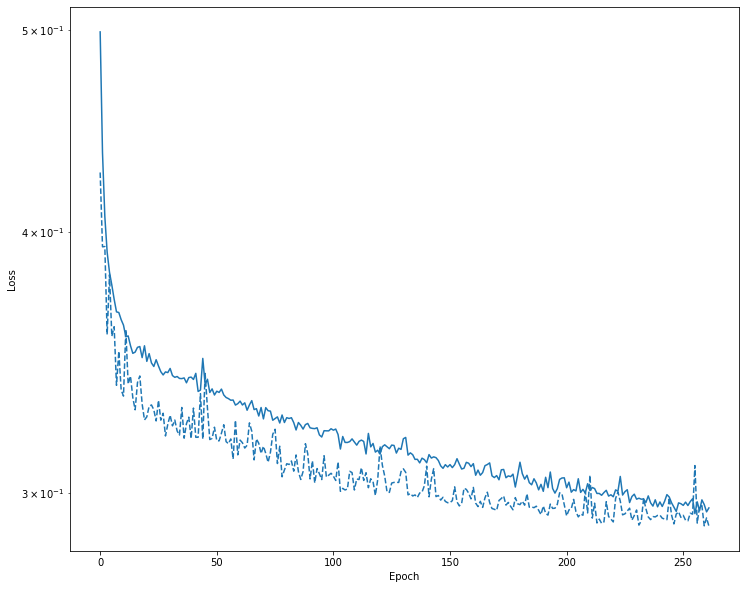

In [30]:
plot_loss(model_history, "Model f1 score", 0)

loss :  0.29011479020118713
tp :  4887.0
fp :  858.0
tn :  4613.0
fn :  609.0
accuracy :  0.866235077381134
precision :  0.8506527543067932
recall :  0.8891921639442444
auc :  0.9459694027900696
prc :  0.9458275437355042
f1 :  0.8692944049835205

Legitimate Transactions Detected (True Negatives):  4613
Legitimate Transactions Incorrectly Detected (False Positives):  858
Fraudulent Transactions Missed (False Negatives):  609
Fraudulent Transactions Detected (True Positives):  4887
Total Fraudulent Transactions:  5496


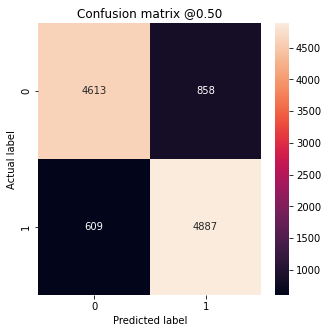

In [31]:
# Evaluar metricas: Baseline
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline, texts=True)

From above, we see that the model is able to achieve an ok F1 score and accuracy. From the confusion matrix, we can see that our model seems to confuse absent points with present points aka false positives, which was improved from the baseline model. One of the reasons for this was the density distribution of the present/absent data points and is evaluated when looking for the optimal threshold.

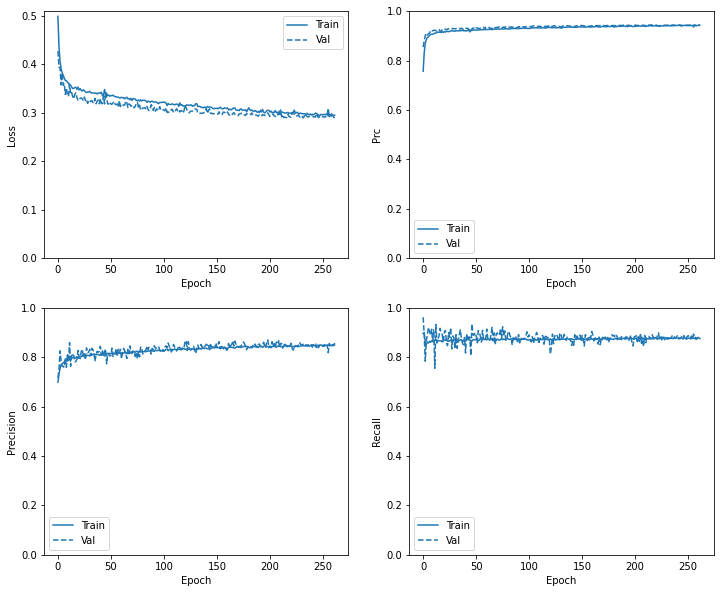

In [32]:
plot_metrics(model_history)

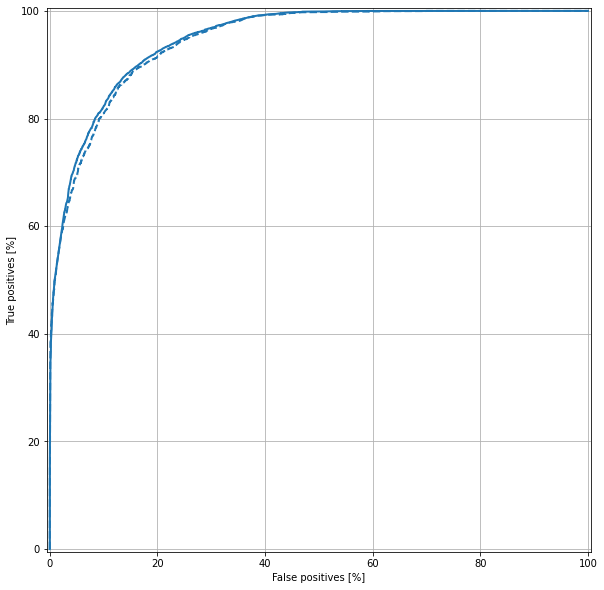

In [33]:
plot_roc("Train labels", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test labels", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

#### Dynamic Threshold

From the evaluation above, it seems that there is an issue with the false positives and it might be related to density of ocurrences in each region. As suggested in the **"Geo-spatial modelling with unbalanced data"** study published in [this study](https://www.degruyter.com/document/doi/10.1515/geo-2015-0031/html) the use of **Dynamic Threshold** can help to mitigate this issue and improve the results when using the model.

In [34]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

# Pickle data
partial_model_data_arr_pkl = partial_frog_data_pkl+"_bbox_arr"
partial_model_data_arr = pickle.load(open(partial_model_data_arr_pkl,'rb'))
infile.close()
print(f'Imported file: {partial_model_data_arr_pkl}\n')
cutoff_threshold_arr = []
for reg in test_regions:
    print(f'Original Box: {reg["bbox"]}')
    partial_model_data = partial_model_data_arr[int(reg["title"])]["partial_model_data"]
    X = (partial_model_data.drop(columns=drop_correlated).drop(['occurrenceStatus'], 1))
    y = partial_model_data.occurrenceStatus.astype(int)
    # Calculate Optimal threshold
    probs=model.predict(scaler.transform(X))
    thresholds = arange(0, 1, 0.001)
    scores = [f1_score(y, to_labels(probs, t)) for t in thresholds]
    ix = argmax(scores)
    cutoff_threshold_arr.append({"bbox":reg["title"], "threshold":thresholds[ix]})
    print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))


Imported file: preprocessed/partial_frog_data_pkl_2009_2019_TimesSubmission_2x_bbox_arr

Original Box: (144.8, -38.5, 145.8, -37.5)
Threshold=0.173, F-Score=0.40000
Original Box: (150.7, -33.5, 151.7, -32.5)
Threshold=0.516, F-Score=0.78920
Original Box: (152.6, -29.0, 153.6, -28.0)
Threshold=0.500, F-Score=0.80513
Original Box: (145.0, -17.7, 146.0, -16.7)
Threshold=0.500, F-Score=0.80836
Original Box: (115.7, -32.5, 116.7, -31.5)
Threshold=0.500, F-Score=0.80836


## Submission

### Get Weather data


In [36]:
# Predict Timeslice
year = year_range[1]
time_slice = (str(year-years_shift_predict)+'-01-01',str(year)+'-12-31')

# Partial frog data
predict_weather_data_pkl = f'preprocessed/predict_weather_data_pkl_{year_range[1]}_{years_shift_predict}'

try:
    infile = open(predict_weather_data_pkl,'rb')
    weather_data = pickle.load(infile)
    infile.close()
    print(f"Import file: {predict_weather_data_pkl}")

except FileNotFoundError:
    weather_data = get_terraclimate(bbox, tc_metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims)
    print(time_slice)
    print(weather_data.band.values)
    # Pickle data
    outfile = open(predict_weather_data_pkl,'wb')
    pickle.dump(weather_data, outfile)
    outfile.close()
    print(f"Save file: {predict_weather_data_pkl}")


Import file: preprocessed/predict_weather_data_pkl_2019_4


In [37]:
# Calculate probability for each pixel point
resultant_image_pkl = f'preprocessed/resultant_image_pkl_{year_range[1]}_{code_attempt_name}'

try:
    infile = open(resultant_image_pkl,'rb')
    resultant_image = pickle.load(infile)
    infile.close()
    print(f"Import file: {resultant_image_pkl}")

except FileNotFoundError:
    if code_attempt_name not in ("5", "6"):
        resultant_image = predict_frogs(weather_data, model)
    else:
        resultant_image = predict_frogs_sequential(weather_data, model, scaler, X.columns.values)
    # Pickle data
    outfile = open(resultant_image_pkl,'wb')
    pickle.dump(resultant_image, outfile)
    outfile.close()
    print(f"Save file: {resultant_image_pkl}")

Import file: preprocessed/resultant_image_pkl_2019_1


### Predict Test Regions

Using threshold 0.17300000000000001 for region 0
Loading data


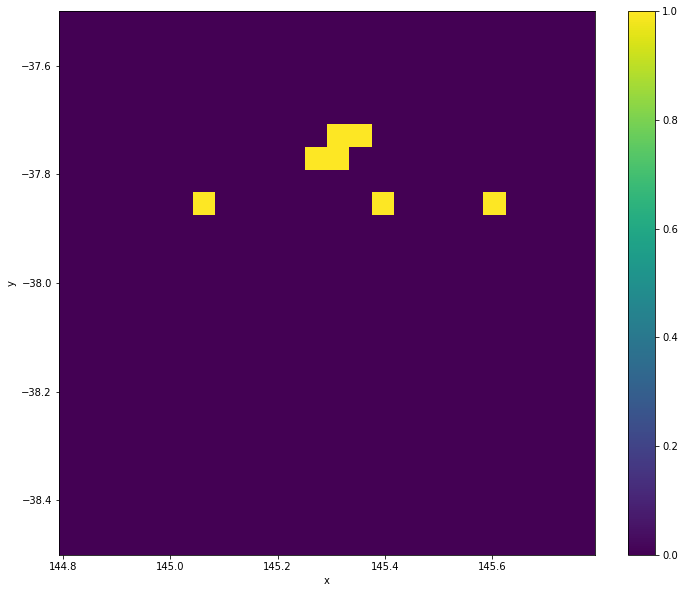

Using threshold 0.516 for region 1
Loading data


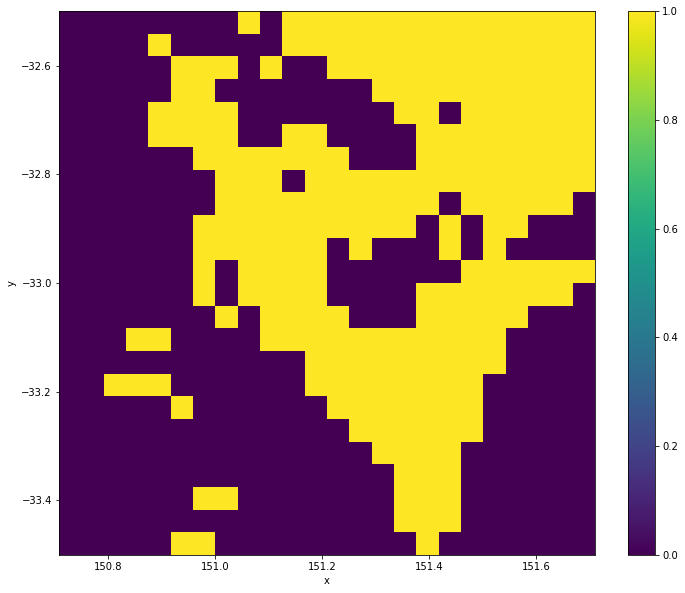

Using threshold 0.5 for region 2
Loading data


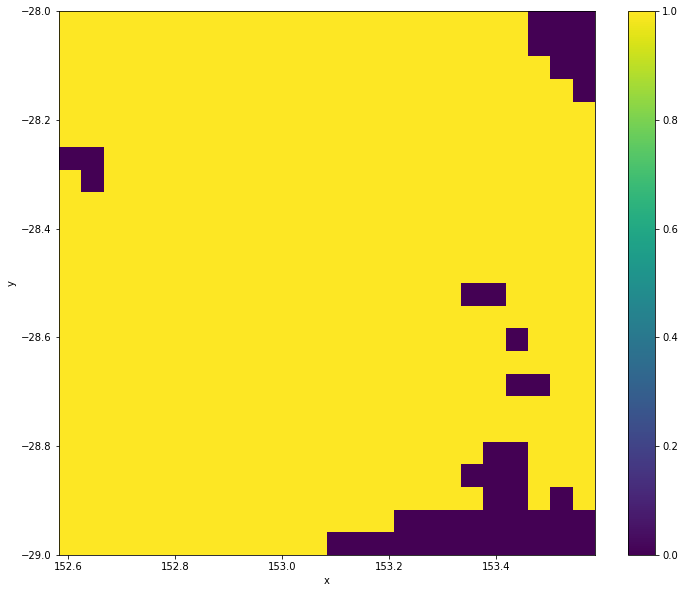

Using threshold 0.5 for region 3
Loading data


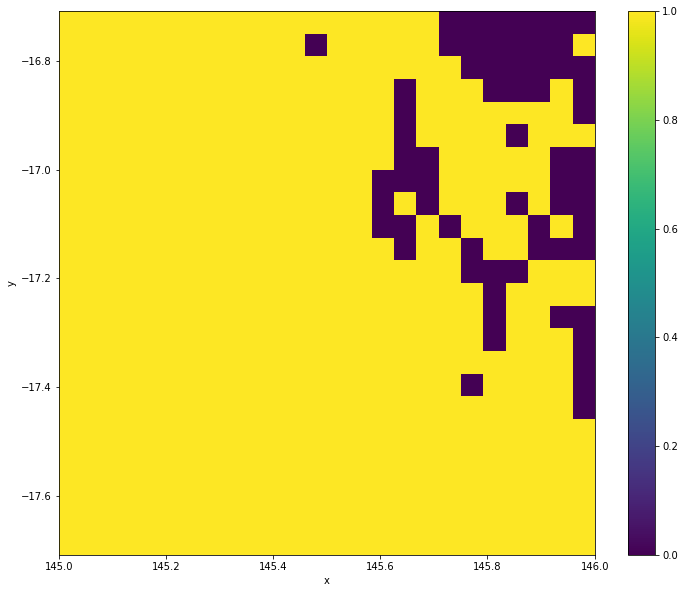

Using threshold 0.5 for region 4
Loading data


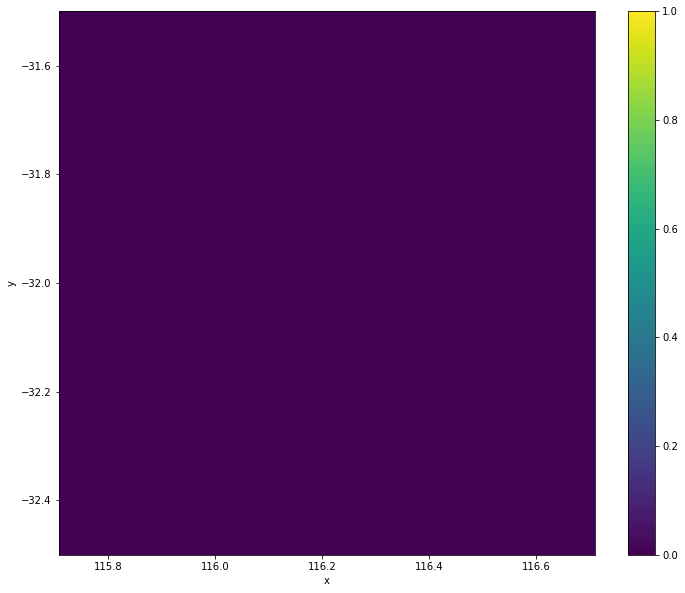

In [43]:
# Predict Test Regions
for i, region in enumerate(test_regions):
    cutoff_threshold = cutoff_threshold_arr[i]["threshold"]
    print(f"Using threshold {cutoff_threshold} for region {region['title']}")
    region['coords'] = filter_bbox(test_file[['id', 'decimalLongitude', 'decimalLatitude']], region['bbox'])
    region['predictors'] = get_terraclimate(region['bbox'], tc_metrics, time_slice=time_slice, assets=assets, features=features)
    region['result'] = predict_frogs_sequential(region['predictors'], model, scaler, X.columns.values) > cutoff_threshold

    if SHOW_PLOTS:
        plt.figure(0)
        region['result'].plot.imshow(x='x', y='y', vmin=0, vmax=1)
        plt.show()


### Submission file

In [39]:
predictions = pd.DataFrame()

for region in test_regions:
    preds = (
        region['result'].rename('occurrenceStatus')
        .sel(
            x=xr.DataArray(region['coords'].decimalLongitude, dims="id", coords={"id": region['coords'].id}), 
            y=xr.DataArray(region['coords'].decimalLatitude, dims="id", coords={"id": region['coords'].id}),
            method="nearest"
        )
        .to_dataframe()
        .reset_index()
        .rename(columns={'x':'decimalLongitude', 'y':'decimalLatitude'})
    )
    predictions = predictions.append(preds)
            
submission = (    
    predictions.merge(
        test_file, 
        on=['decimalLongitude', 'decimalLatitude'], 
        how='left', suffixes = ('', '_'))
    [test_file.columns]
    .fillna(0)
    .astype({col:'int' for col in test_file.columns[3::]})
)

# Save to output folder
submission.to_csv(output_submission, index=None)

print(f'Submission file saved: {output_submission}')
submission.sample(10)

Submission file saved: challenge_1_submission_benchmark_keras_D5_A1_bboxthr.csv


,id,decimalLatitude,decimalLongitude,occurrenceStatus
2690,2690,-28.687500,153.270833,1
923,923,-37.979167,145.312500,0
696,696,-37.937500,145.520833,0
3078,3078,-28.562500,153.062500,1
649,649,-38.395833,144.854167,0
324,324,-38.187500,145.229167,0
2957,2957,-28.062500,153.354167,1
2265,2265,-33.020833,151.562500,1
2120,2120,-33.229167,151.312500,1
3225,3225,-28.062500,153.354167,1


### Probability Heatmap

(144.8, -38.5, 145.8, -37.5)
(150.7, -33.5, 151.7, -32.5)
(152.6, -29.0, 153.6, -28.0)
(145.0, -17.7, 146.0, -16.7)
(115.7, -32.5, 116.7, -31.5)


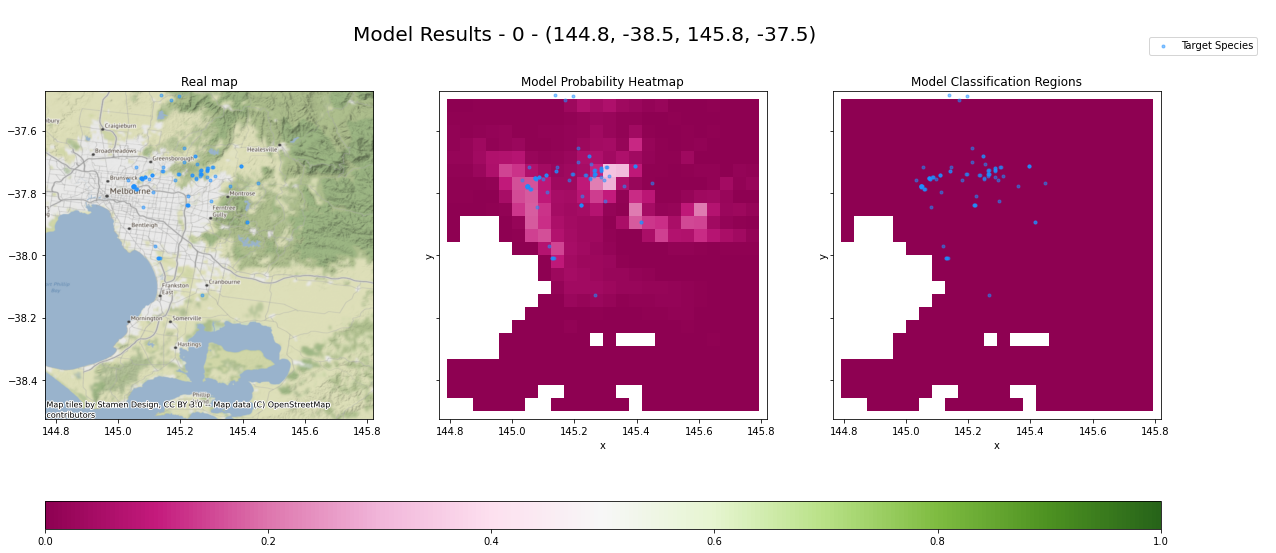

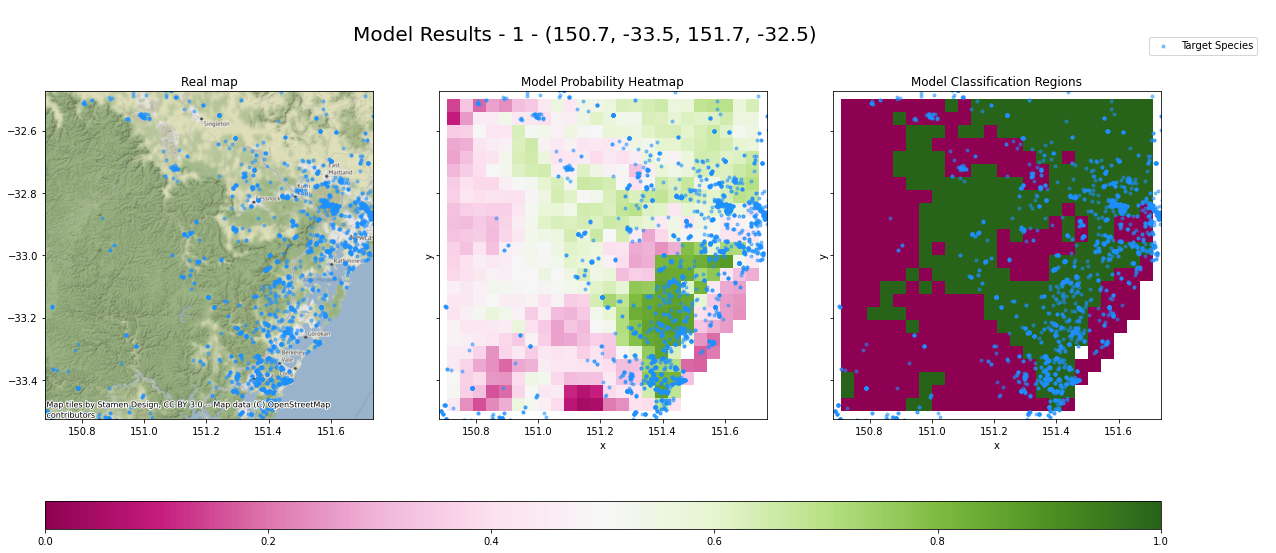

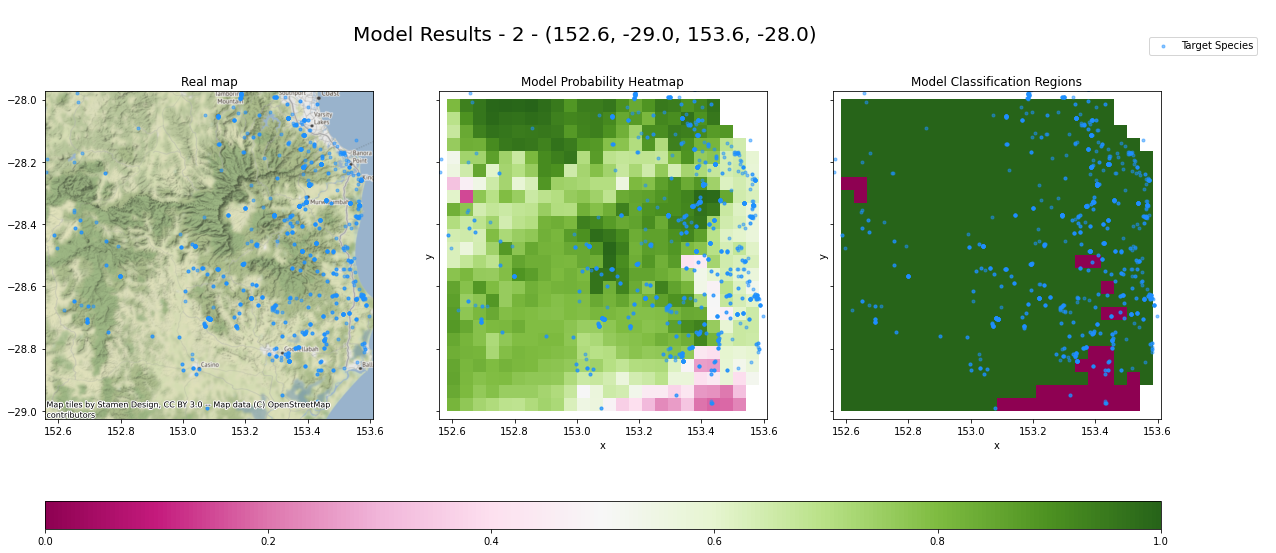

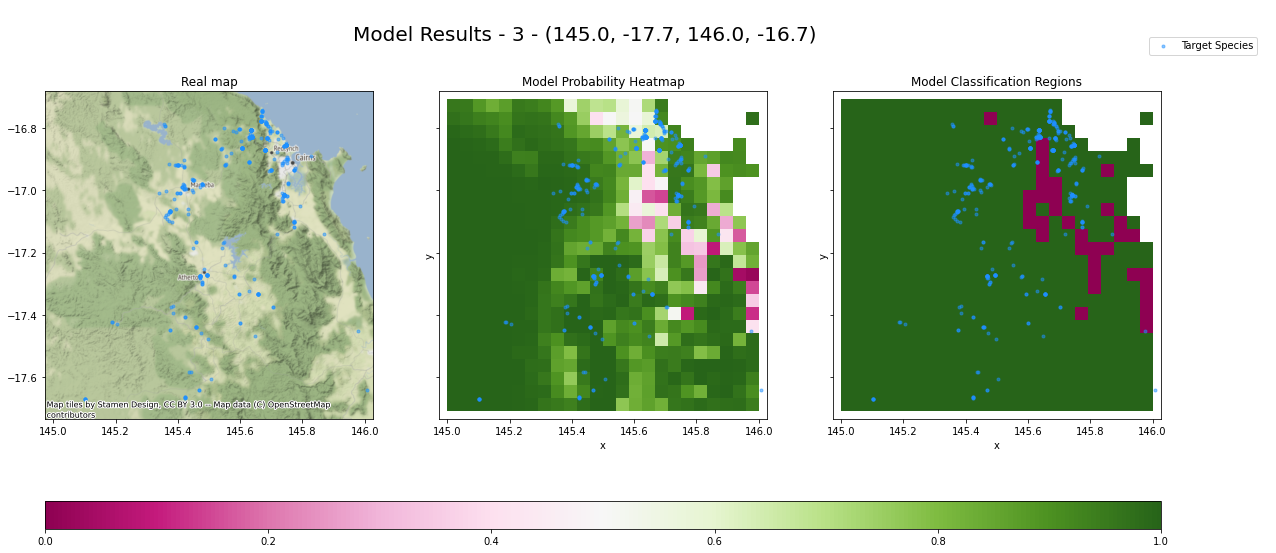

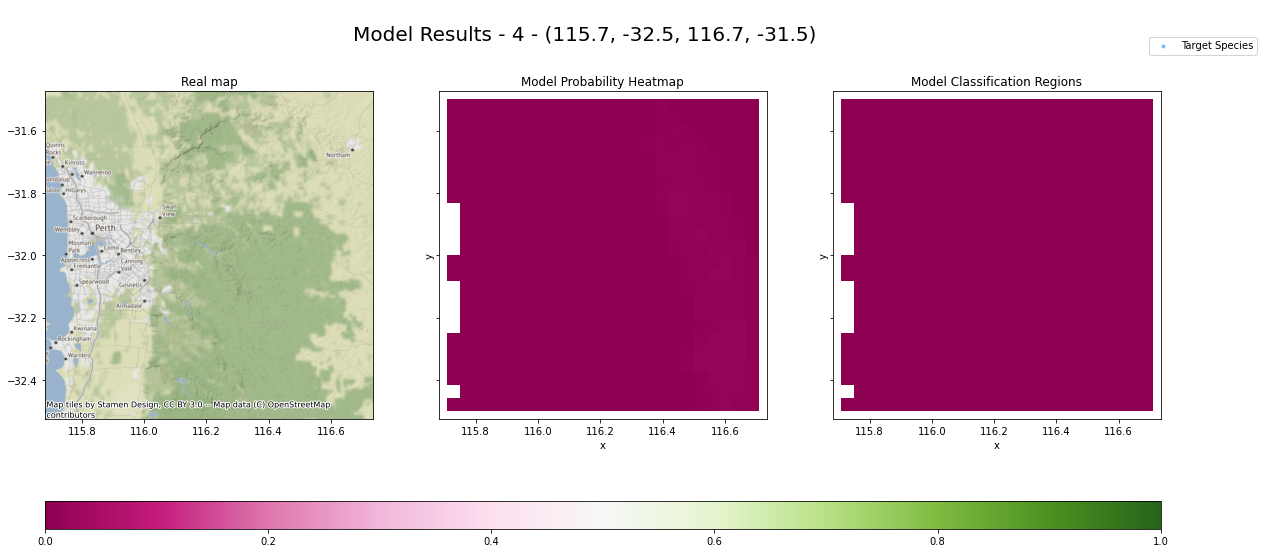

In [40]:
# Obtain predictor data for each region and get predictor image
if SHOW_PLOTS:
    for i, region in enumerate(test_regions):
        print(region['bbox'])
        partial_frog_data = get_frogs(dataset_path, year_range=year_range, bbox=bbox)
        partial_frog_data = (partial_frog_data.assign(occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0)))
        weather_data_i = get_terraclimate(region['bbox'], tc_metrics, time_slice=time_slice, assets=assets, features=features, verbose=False)
        resultant_image_i = predict_frogs_sequential(weather_data_i, model, scaler, X.columns.values)
        plot_heatmap(resultant_image_i, partial_frog_data, f"Model Results - {region['title']} - {region['bbox']}")